# Removing batch effects using pyCombat

If you measure samples in batches on different machines or on different days batch effect can occur where performance between machines is slightly different or external factors (like ambient temperature) affect a device's readings on different days. So to overcome this step 1 is to properly randomize your samples. Step two is to get rid of the batch effect and this can be done using pyCombat.

Here a few syntetic datasets are generated with a different kind of batch effect and we check if pyCombat is able to pick it up and remove it correctly.

In [1]:
%load_ext nb_black

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1910)


<IPython.core.display.Javascript object>

In [2]:
num_samples = 200  # number of samples per batch

batches = ["Batch 1"] * num_samples + ["Batch 2"] * num_samples
df = pd.DataFrame(
    {
        "batch": batches,
        # Feature 1-3 are normal distributed, we'll shift one, multiply another and leave one untouched
        "feature_one": np.concatenate(
            [np.random.randn(num_samples), np.random.randn(num_samples) + 1]
        ),
        "feature_two": np.concatenate(
            [np.random.randn(num_samples), np.random.randn(num_samples) * 1.3]
        ),
        "feature_three": np.concatenate(
            [np.random.randn(num_samples), np.random.randn(num_samples)]
        ),
        # Feature 4-6 are uniformly distributed, we'll shift one, multiply another and leave one untouched
        "feature_four": np.concatenate(
            [np.random.rand(num_samples), np.random.rand(num_samples) + 0.2]
        ),
        "feature_five": np.concatenate(
            [np.random.rand(num_samples), np.random.rand(num_samples) * 1.3]
        ),
        "feature_six": np.concatenate(
            [np.random.rand(num_samples), np.random.rand(num_samples)]
        ),
    }
)

<IPython.core.display.Javascript object>

In [3]:
# Look at first and last elements
df.iloc[[0, 1, 2, -1, -2, -3]]

,batch,feature_one,feature_two,feature_three,feature_four,feature_five,feature_six
0,Batch 1,-0.560251,-0.329007,-0.391515,0.705579,0.067287,0.318247
1,Batch 1,-0.676682,-1.219296,0.488081,0.940643,0.786043,0.374624
2,Batch 1,0.557334,-0.025515,1.478300,0.851690,0.340614,0.682563
399,Batch 2,0.253740,-0.100651,-0.268410,0.788433,0.740919,0.028127
398,Batch 2,-0.345181,-0.420646,-0.876879,0.327634,0.815336,0.783284
397,Batch 2,-0.189546,1.500048,-1.136106,0.536194,1.118575,0.155961


<IPython.core.display.Javascript object>

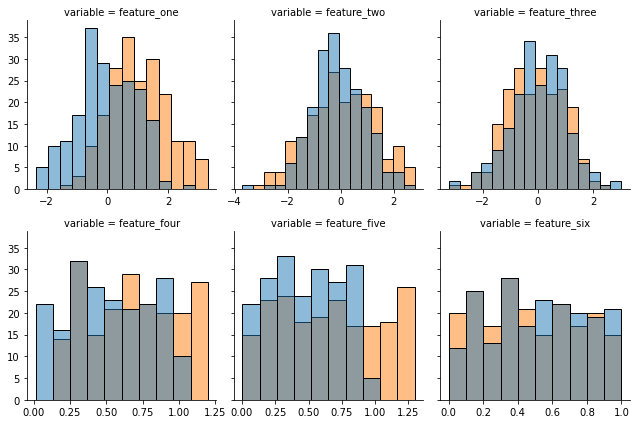

<IPython.core.display.Javascript object>

In [4]:
long_df = df.melt(id_vars=["batch"])

g = sns.FacetGrid(
    long_df, col="variable", height=3, aspect=1, sharex=False, col_wrap=3,
)
g.map_dataframe(sns.histplot, x="value", hue="batch")
plt.savefig("./img/pycombat_synthetic_dataset.png", dpi=200)
plt.show()

In [5]:
from combat.pycombat import pycombat

corrected_df = pycombat(df.drop(columns=["batch"]).transpose(), df["batch"]).transpose()
corrected_df.head()

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


,feature_one,feature_two,feature_three,feature_four,feature_five,feature_six
0,-0.062237,-0.276713,-0.429908,0.790984,0.089940,0.298606
1,-0.180598,-1.270888,0.458374,1.035210,0.921394,0.356112
2,1.073879,0.062193,1.458372,0.942790,0.406123,0.670221
3,-1.299430,-1.993188,1.117924,0.775037,0.635035,0.022828
4,2.080704,0.590844,0.470759,0.395933,0.626676,0.781287


<IPython.core.display.Javascript object>

In [6]:
long_corrected_df = corrected_df.melt()
long_corrected_df

,variable,value
0,feature_one,-0.062237
1,feature_one,-0.180598
2,feature_one,1.073879
3,feature_one,-1.299430
4,feature_one,2.080704
...,...,...
2395,feature_six,0.858274
2396,feature_six,0.248279
2397,feature_six,0.178785
2398,feature_six,0.791470


<IPython.core.display.Javascript object>

In [7]:
merged_df = pd.merge(
    long_df,
    long_corrected_df,
    left_index=True,
    right_index=True,
    suffixes=("_raw", "_corrected"),
)
merged_df

,batch,variable_raw,value_raw,variable_corrected,value_corrected
0,Batch 1,feature_one,-0.560251,feature_one,-0.062237
1,Batch 1,feature_one,-0.676682,feature_one,-0.180598
2,Batch 1,feature_one,0.557334,feature_one,1.073879
3,Batch 1,feature_one,-1.777265,feature_one,-1.299430
4,Batch 1,feature_one,1.547736,feature_one,2.080704
...,...,...,...,...,...
2395,Batch 2,feature_six,0.851684,feature_six,0.858274
2396,Batch 2,feature_six,0.227115,feature_six,0.248279
2397,Batch 2,feature_six,0.155961,feature_six,0.178785
2398,Batch 2,feature_six,0.783284,feature_six,0.791470


<IPython.core.display.Javascript object>

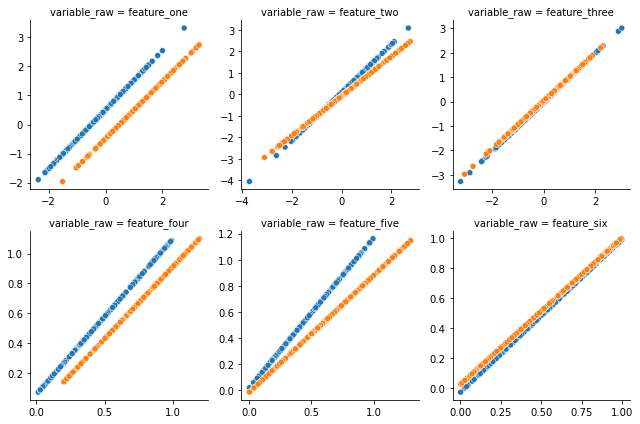

<IPython.core.display.Javascript object>

In [8]:
g = sns.FacetGrid(
    merged_df,
    col="variable_raw",
    height=3,
    aspect=1,
    sharex=False,
    sharey=False,
    col_wrap=3,
)
g.map_dataframe(sns.scatterplot, x="value_raw", y="value_corrected", hue="batch")
plt.savefig("./img/pycombat_corrections.png", dpi=200)
plt.show()